# Gene Ontology Embeddings

In [4]:
%load_ext autoreload
%autoreload 2

import sys, os
import json
import pickle

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import pandas as pd
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import goatools
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy

from dpp.methods.lci.lci_method import LCIModule
from dpp.experiments.go_enrichment import GOEnrichment
from dpp.data.network import PPINetwork
from dpp.data.go import load_go_annotations
from dpp.util import Params, prepare_sns, load_mapping
from dpp.data.embeddings import write_embeddings, load_embeddings
from dpp.data.associations import load_diseases
os.chdir("/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction")
#os.chdir("/dfs/scratch0/sabri/disease-protein-prediction")
prepare_sns(sns, {})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [5]:
diseases_dict = load_diseases("data/associations/disgenet-associations.csv", exclude_splits=['none'])

In [6]:
# load network
network = PPINetwork("data/networks/bio-pathways-network.txt")
n = len(network)

In [7]:
# load entrez mapping
symbol_to_entrez = load_mapping("data/protein/symbol_to_entrez.txt", "\t")
entrez_to_symbol = {int(entrez): symbol for symbol, entrez in symbol_to_entrez.items() if entrez!=""}

In [8]:
term_to_proteins = load_go_annotations(network.get_proteins(), levels=[1,2,3,4,5])

data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms
  20,385 items READ: data/go/gene2go.txt


## Build Binary Matrix

In [9]:
def build_binary_go_emb(network, term_to_proteins):
    matrix = np.zeros((len(network), len(term_to_proteins)))
    for idx, (term, proteins) in enumerate(term_to_proteins.items()):
        matrix[network.get_nodes(proteins), idx] = 1
    return matrix

binary_go_emb = build_binary_go_emb(network, term_to_proteins)

## PCA

In [11]:
pca_go_emb = PCA(n_components=1024).fit_transform(binary_go_emb)

In [12]:
write_embeddings(pca_go_emb, "data/embeddings/pca_go_d1024.txt", network)

In [13]:
pca_go_emb2 = load_embeddings("data/embeddings/pca_go_d1024.txt", network)

## T-SNE

In [16]:
tsne_go_emb = TSNE(n_components=2).fit_transform(pca_go_emb)

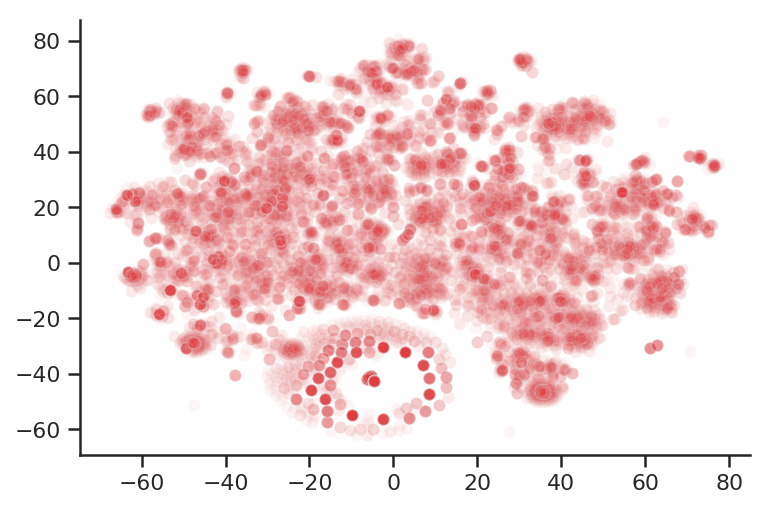

In [22]:
sns.scatterplot(x = tsne_go_emb[:, 0], y=tsne_go_emb[:, 1], alpha=0.05)
sns.despine()

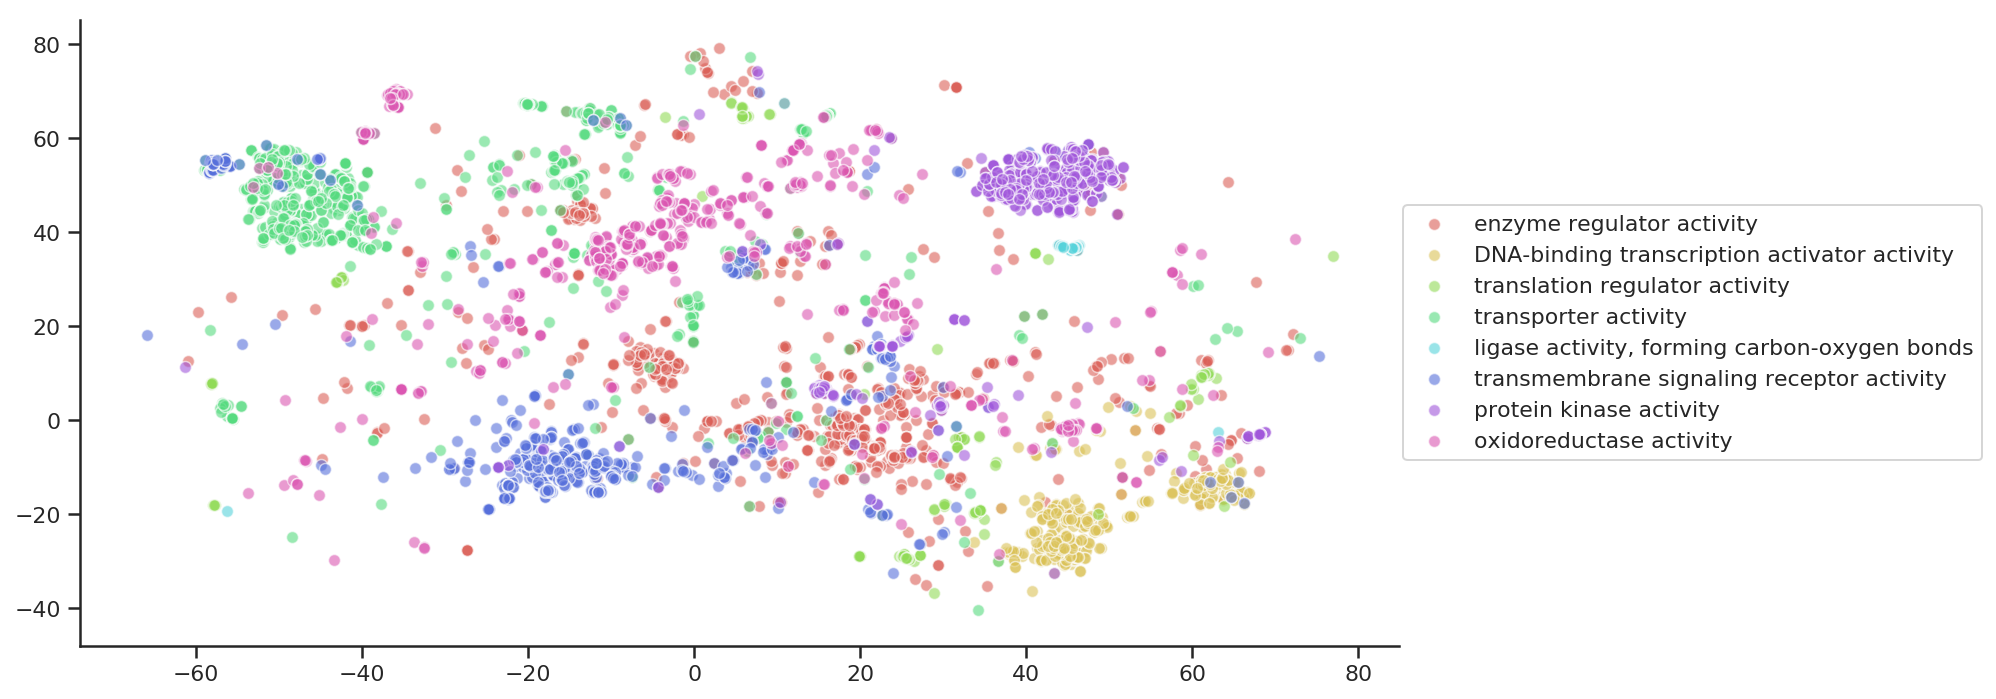

In [128]:
plt.figure(figsize=(10,5))

sns.set_palette(sns.color_palette("hls", 8))
terms = ["enzyme regulator activity",
         "DNA-binding transcription activator activity", "translation regulator activity", 
         "transporter activity", "ligase activity, forming carbon-oxygen bonds",
        "transmembrane signaling receptor activity", "protein kinase activity", "oxidoreductase activity"]
for term in terms:
    nodes = network.get_nodes(term_to_proteins[term])
    sns.scatterplot(x = tsne_go_emb[nodes, 0], y=tsne_go_emb[nodes, 1], alpha=0.6, label=term)
sns.despine()
plt.tight_layout()
lgd = plt.legend(loc="right", bbox_to_anchor=(1.45,.5 ))
plt.savefig("experiments/dpp_evaluate/lci-go/_figures/tsne.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


In [87]:
term_to_proteins = load_go_annotations(network.get_proteins(), levels=[1,2,3])

data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms
  20,385 items READ: data/go/gene2go.txt


In [88]:
term_to_proteins.keys()

dict_keys(['cell part', 'immune effector process', 'immune system process', 'cell activation involved in immune response', 'vesicle', 'exocytosis', 'myeloid leukocyte activation', 'extracellular organelle', 'cellular process', 'extracellular region part', 'establishment of localization', 'cell activation', 'cytoplasmic part', 'organelle lumen', 'intracellular part', 'secretion by cell', 'leukocyte degranulation', 'extracellular matrix', 'membrane-enclosed lumen', 'organelle', 'membrane-bounded organelle', 'cytoplasmic vesicle part', 'localization', 'organelle part', 'intracellular organelle lumen', 'transport', 'intracellular organelle part', 'vesicle lumen', 'leukocyte activation', 'extracellular vesicle', 'leukocyte activation involved in immune response', 'nucleoside-triphosphatase regulator activity', 'enzyme regulator activity', 'enzyme binding', 'enzyme activator activity', 'growth factor binding', 'binding', 'cellular component disassembly', 'regulation of metabolic process', 'c